# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard.

In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

sw = stopwords.words("english")

In [2]:
# change `data_location` to the location of the folder on your machine.
data_location = "/users/Chris/Downloads/M1 Results/"

# These subfolders should still work if you correctly stored the data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [3]:
# Define the path to the folder containing lyrics data
lyrics_folder_path = os.path.join(data_location, lyrics_folder)

# Initialize a list to store the rows of data
lyrics_data = []

# Iterate through the lyrics data files
for artist in os.listdir(lyrics_folder_path):
    artist_path = os.path.join(lyrics_folder_path, artist)
    for song in os.listdir(artist_path):
        # Extract the song name from the filename
        song_name = os.path.splitext(song)[0].split("_")[1]
        song_path = os.path.join(artist_path, song)

        with open(song_path, 'r') as f:
            # Read the lyrics from the file
            lyric = f.read()

        # Append the data as a tuple to the list
        lyrics_data.append((artist, song_name, lyric))

# Create a data frame
lyrics_df = pd.DataFrame(lyrics_data, columns = ["artist", "song", "lyrics"])
lyrics_df.head()

,artist,song,lyrics
0,cher,88degrees,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n..."
1,cher,adifferentkindoflovesong,"""A Different Kind Of Love Song""\n\n\n\nWhat if..."
2,cher,afterall,"""After All""\n\n\n\nWell, here we are again\nI ..."
3,cher,again,"""Again""\n\n\n\nAgain evening finds me at your ..."
4,cher,alfie,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs..."


In [4]:
# Read in the Twitter data

# Define the path to the folder containing Twitter data
twitter_folder_path = os.path.join(data_location, twitter_folder)

# Initialize a list to store the rows of data
tweets_data = []

# Identify files that contain "followers_data" in their names
desc_files = [f for f in os.listdir(twitter_folder_path) if "followers_data" in f]

# Iterate through the selected files and extract data
for f in desc_files:
    # Extract the artist name from the filename
    artist = f.split("_")[0]

    # Open the file and read its contents
    with open(os.path.join(twitter_folder_path, f), 'r', encoding = 'utf8') as infile:
        # Skip the header line
        next(infile)
        for line in infile:
            line = line.strip().split("\t")
            # Extract the description and store it as a tuple
            description = line[-1]
            tweets_data.append((artist, description))

# Create a data frame
tweets_df = pd.DataFrame(tweets_data, columns = ["artist", "description"])
tweets_df.head()

,artist,description
0,cher,1014
1,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
2,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
3,cher,csu
4,cher,Writer @Washinformer @SpelmanCollege alumna #D...


In [5]:
# Read in the positive and negative words and the tidytext sentiment. Store these so that the positive words are associated with a score of +1
# and negative words are associated with a score of -1. You can use a dataframe or a dictionary for this.

# Read in positive words
positive_words = pd.read_csv("/Users/Chris/Downloads/M1 Results/positive-words.txt", header = None, comment = ";", encoding = 'latin-1', names = ["word"])
positive_words["sentiment"] = 1

# Read in negative words
negative_words = pd.read_csv("/Users/Chris/Downloads/M1 Results/negative-words.txt", header = None, comment = ";", encoding = 'latin-1', names = ["word"])
negative_words["sentiment"] = -1

# Read in tidytext sentiment
tidytext_sentiment = pd.read_csv("/Users/Chris/Downloads/M1 Results/tidytext_sentiments.txt", sep = "\t")
tidytext_sentiment["sentiment"] = tidytext_sentiment["sentiment"].map({"negative": -1, "positive": 1})

# Combine sentiments into a data frame
sentiment_scores = pd.concat([positive_words, negative_words, tidytext_sentiment])
sentiment_scores.reset_index(drop = True, inplace = True)

# Drop duplicate values
sentiment_scores = sentiment_scores.drop(columns = 'lexicon').drop_duplicates()
sentiment_scores.head()

,word,sentiment
0,a+,1
1,abound,1
2,abounds,1
3,abundance,1
4,abundant,1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [6]:
# Define sentiment scores for positive and negative words
positive_score = 1
negative_score = -1

# Create a dictionary from the sentiment_scores data frame
word_sentiment_dict = sentiment_scores.set_index('word').to_dict()['sentiment']

# Function to calculate Bing Liu sentiment score for text
def bing_liu_score(text):
    sentiment_score = 0
    # Tokenize the text into a bag of words
    bag_of_words = word_tokenize(text.lower()) 
    
    # Calculate sentiment score for each word in the bag
    for word in bag_of_words:
        if word in word_sentiment_dict:
            sentiment_score += word_sentiment_dict[word]
    
    # Calculate the average sentiment score for the text    
    return (sentiment_score / len(bag_of_words))

# Apply the sentiment scoring function to the lyrics data frame
lyrics_df['sentiment_score'] = lyrics_df['lyrics'].apply(bing_liu_score)
lyrics_df.head()

,artist,song,lyrics,sentiment_score
0,cher,88degrees,"""88 Degrees""\n\n\n\nStuck in L.A., ain't got n...",0.027701
1,cher,adifferentkindoflovesong,"""A Different Kind Of Love Song""\n\n\n\nWhat if...",0.135889
2,cher,afterall,"""After All""\n\n\n\nWell, here we are again\nI ...",-0.015974
3,cher,again,"""Again""\n\n\n\nAgain evening finds me at your ...",-0.011628
4,cher,alfie,"""Alfie""\n\n\n\nWhat's it all about, Alfie?\nIs...",0.063953


In [7]:
# Calculate the average sentiment score per artist
lyrics_df.groupby('artist')['sentiment_score'].mean()

artist
cher     0.026900
robyn    0.029797
Name: sentiment_score, dtype: float64

### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Robyn has the higher average sentiment per song at 0.029797230618827792.

In [8]:
# Calculate the average sentiment score per artist
cher_avg_sentiment = lyrics_df[lyrics_df['artist'] == 'cher']['sentiment_score'].mean()
robyn_avg_sentiment = lyrics_df[lyrics_df['artist'] == 'robyn']['sentiment_score'].mean()

# Print the results
print(f"Cher's songs have an average sentiment of {cher_avg_sentiment}")
print(f"Robyn's songs have an average sentiment of {robyn_avg_sentiment}")

Cher's songs have an average sentiment of 0.026899860906400327
Robyn's songs have an average sentiment of 0.029797230618827792


---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The three songs with the highest sentiment scores for Cher are `My Love`, `Love and Understanding`, and `Sunny`. These songs tend to contain positive and uplifting words and themes, which contribute to their high sentiment scores. Words such as "love," "good," "bright," "sincere," and "sweet" create a positive and joyful atmosphere in the lyrics, influencing the sentiment score positively.

Conversely, the three songs with the lowest sentiment scores are `Bang Bang`, `Bang Bang (My Baby Shot Me Down)`, and `Cry Myself to `Sleep`. These songs include words and phrases associated with negative emotions and experiences, such as "cry," "gone," "paralyzed," "lies," "fight," and "tears." These negative connotations contribute to the lower sentiment scores and evoke emotions related to sadness in the listener.

In [9]:
# Cher's highest sentiment songs

# Filter the data frame to select only songs by Cher
cher_song = lyrics_df.loc[lyrics_df['artist'] == 'cher']

# Sort the songs by sentiment score in descending order to get the highest sentiment songs
highest_cher = cher_song.sort_values('sentiment_score', ascending = False).head(3)
highest_cher

,artist,song,lyrics,sentiment_score
181,cher,mylove,"""My Love""\n\n\n\nWhen I go away\nI know my hea...",0.222222
155,cher,loveandunderstanding,"""Love And Understanding""\n\n\n\nHere, here in ...",0.192926
237,cher,sunny,"""Sunny""\n\n\n\nSunny, yesterday my life was fi...",0.192708


In [10]:
# Cher's lowest sentiment songs

# Sort the songs by sentiment score in ascending order to get the lowest sentiment songs
lowest_cher = cher_song.sort_values('sentiment_score', ascending = True).head(3)
lowest_cher

,artist,song,lyrics,sentiment_score
16,cher,bangbang,"""Bang-Bang""\n\n\n\nBang bang you shot me down\...",-0.243056
17,cher,bangbangmybabyshotmedown,"""Bang Bang (My Baby Shot Me Down)""\n\n\n\nI wa...",-0.182292
42,cher,crymyselftosleep,"""Cry Myself To Sleep""\n\n\n\nEvery night, I la...",-0.111111


In [11]:
# Print Cher's highest sentiment songs' lyrics
for i in [181, 155, 237]:
    print(highest_cher['lyrics'][i])
    print('\n')

# Print Cher's lowest sentiment songs' lyrics
for i in [16, 17, 42]:
    print(lowest_cher['lyrics'][i])
    print('\n')

"My Love"



When I go away
I know my heart can stay with my love
It's understood
Everywhere with my love
My love does it good, whoa
My love, oh only my love
My love does it good

And when the cupboard's bare
I'll still find something there with my love
It's understood
Everywhere with my love
My love does it so good, whoa
My love, oh only my love
My love does it good

Only my love, oh only my love
Only my love, hold the other things to me
Oh, only my love, oh only my love
Only my love does it good to me

Everywhere with my love
Don't you see my love
It does it so good
Oh, only my love, only my love
My love does it good

Don't ever ask me why
I never say "good-bye" to my love
It's understood
'Cause everywhere with my love
My love does it good, whoa
Only my love, oh only my love
My love does it good

Oh only my love
Only my love does it good to me,whoa



"Love And Understanding"



Here, here in this world
Where do we go? Where can we turn?
When we need some love
It seems that love just

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: The three songs with the highest sentiment scores for Robyn are `Baby Forgive Me`, `Love is Free`, and `We Dance to the Beat`. These songs feature words and themes such as the opportunity for a fresh start and the joy of celebrating life that contribute to their high sentiment scores. Words such as "brave," "wise," "love," "power," "happy," and "smile" all contribute to positive sentiments.

Conversely, the songs with the lowest sentiment scores are `Don't Fucking Tell Me What To Do` and `Criminal Intent`. The songs touch on themes related to legal troubles and criminal activity, further emphasizing a darker tone. Words like "killing," "wrong," "incarcerated," and "frowned upon" all contribute to the negative sentiment. Note that `Don't Fucking Tell Me What To Do` appears twice, which may indicate that there may have been an error in preprocessing.

In [12]:
# Robyn's highest sentiment songs

# Filter the data frame to select only songs by Robyn
robyn_song = lyrics_df.loc[lyrics_df['artist'] == 'robyn']

# Sort the songs by sentiment score in descending order to get the highest sentiment songs
highest_robyn = robyn_song.sort_values('sentiment_score', ascending = False).head(3)
highest_robyn

,artist,song,lyrics,sentiment_score
319,robyn,babyforgiveme,"""Baby Forgive Me""\n\n\n\nHere come the night\n...",0.245509
380,robyn,loveisfree,"""Love Is Free""\n\n\n\nFree\nLove is free, baby...",0.223986
415,robyn,wedancetothebeat114528,"""We Dance To The Beat""\n\n\n\nWe dance to the ...",0.133858


In [13]:
# Robyn's lowest sentiment songs

# Sort the songs by sentiment score in ascending order to get the lowest sentiment songs
lowest_robyn = robyn_song.sort_values('sentiment_score', ascending = True).head(3)
lowest_robyn

,artist,song,lyrics,sentiment_score
343,robyn,dontfuckingtellmewhattodo114520,"""Don't Fucking Tell Me What To Do""\n\n\n\nMy d...",-0.194690
342,robyn,dontfuckingtellmewhattodo,"""Don't Fucking Tell Me What To Do""\n\n\n\nMy d...",-0.194690
334,robyn,criminalintent,"""Criminal Intent""\n\n\n\nSomebody alert the au...",-0.101167


In [14]:
# Print Robyn's highest sentiment songs' lyrics
for i in [319, 380, 415]:
    print(highest_robyn['lyrics'][i])
    print('\n')

# Print Robyn's lowest sentiment songs' lyrics
for i in [343, 342, 334]:
    print(lowest_robyn['lyrics'][i])
    print('\n')

"Baby Forgive Me"



Here come the night
In your eyes
Baby, be brave
Be wise
It's up to you
You do what you like, mmm
Won't you give it a chance, baby?
Just one more try

Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me

(Won't you give it a chance, baby?)
Won't you give it a chance, baby?
Just one more try
One more try
Yeah, eh

You got the power
You set the price
But baby, be fair
Be nice
You say you want to be happy
Then you got to put your love on the line
Just let me make you smile again, baby
I know we can work it out
Yes, I know we can

Baby forgive me
Yeah
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me



"Love Is Free"



Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to you, baby
Chica boom chica boom chica boom
Chica boom chica boom chica boom
Free
Love is free, baby
Free
Love is free, baby
Boom boom boom boom boom chica boom
Let me give it to y

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

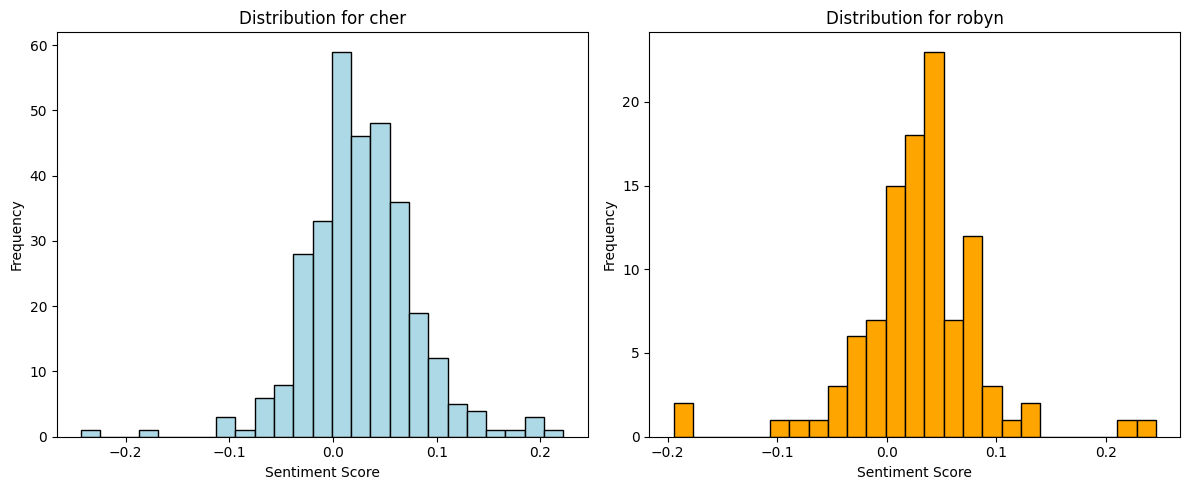

In [15]:
# Individual distributions of sentiment scores

# Get each artist
artists = lyrics_df['artist'].unique()
num_artists = len(artists)

# Define a list of colors for the plots
colors = ['lightblue', 'orange']

# Create subplots for each artist
fig, axes = plt.subplots(1, num_artists, figsize = (12, 5))

for i, artist in enumerate(artists):
    artist_data = lyrics_df[lyrics_df['artist'] == artist]['sentiment_score']
    ax = axes[i]
    ax.hist(artist_data, bins = 25, edgecolor = 'black', color = colors[i % len(colors)])
    ax.set_title(f'Distribution for {artist}')
    ax.set_xlabel('Sentiment Score')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

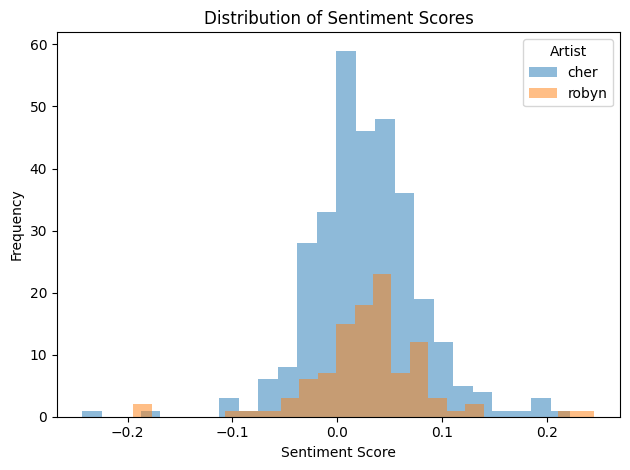

In [16]:
# Stacked distributions of sentiment scores

for artist in artists:
    plt.hist(lyrics_df[lyrics_df['artist'] == artist]['sentiment_score'], bins = 25, alpha = 0.5, label = artist)

plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend(title = 'Artist')
plt.tight_layout()
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [17]:
# Define list of positive and negative emojis
positive_emojis = ["😄", "😊", "🙂", "🥰", "😘", "🤩", "🥳", "💖", "💗", "💕", "🙌", "👏", "👍", "💯", "🔥", "💃", "🎈", "🎉", "🌟"]
negative_emojis = ["😞", "😔", "😢", "😠", "😒", "😕", "😖", "😣", "😩", "🙁", "😭", "😡", "🤬", "😓", "👿", "🖤", "💔", "👎", "💀"]

# Create a dictionary with emojis and sentiment values
emoji_dict = {emoji: 1 for emoji in positive_emojis}  # Positive sentiment
emoji_dict.update({emoji: -1 for emoji in negative_emojis})  # Negative sentiment

# Map emojis from the 'description' column
tweets_df['emoji'] = tweets_df['description'].map(emoji.distinct_emoji_list)

# Count emojis and calculate sentiment score
def count_emojis(text):
    sentiment_score = 0
    emojis = [c for c in text if c in emoji_dict]
    for emoji in emojis:
        sentiment_score += emoji_dict[emoji]
    return sentiment_score

# Display the resulting data frame
tweets_df['emoji_count'] = tweets_df['description'].apply(count_emojis)
tweets_df

,artist,description,emoji,emoji_count
0,cher,1014,[],0
1,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,[],0
2,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,"[🍒, 🧡, 💓, 💜]",0
3,cher,csu,[],0
4,cher,Writer @Washinformer @SpelmanCollege alumna #D...,[],0
...,...,...,...,...
4353170,robynkonichiwa,"singer of songs, type 1 diabetic, tired $jakel...",[],0
4353171,robynkonichiwa,Dadx2/ Con-Arch/ Photographer/ DK #stemgrønnes...,[],0
4353172,robynkonichiwa,A year to change a life is still a year ✨😌,"[😌, ✨]",0
4353173,robynkonichiwa,Head of Consumer - Mango. Made in Melbourne. R...,[],0


Q: What is the average sentiment of your two artists? 

A: Cher's average Tweet sentiment is 0.012072 and Robyn's average Tweet sentiment is 0.006209.

In [18]:
# Calculate the number of artists
artist_counts = tweets_df['artist'].value_counts()

# Calculate the average sentiment for each artist
average_sentiments = tweets_df.groupby('artist')['emoji_count'].mean()

# Create a data frame of results
result_df = pd.DataFrame({
    'Artist': artist_counts.index,
    'Number of Emojis': artist_counts.values,
    'Average Sentiment': average_sentiments
})

# Reset the index for the result data frame
result_df.reset_index(drop = True, inplace = True)
result_df

,Artist,Number of Emojis,Average Sentiment
0,cher,3994803,0.012072
1,robynkonichiwa,358372,0.006209


---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: Cher's most popular positive emoji is 💕 and negative emoji is 🖤. Robyn's most popular positive emoji is 💕 and negative emoji is 🖤.

In [19]:
# Filter Cher's tweets
cher_tweets = tweets_df[(tweets_df['artist'] == 'cher')]

# Extract all emojis from Cher's tweets
cher_emojis = [emoji for emojis in cher_tweets['emoji'] for emoji in emojis]

# Count the occurrence of positive and negative emojis
cher_positive_emojis = [emoji for emoji in cher_emojis if emoji in positive_emojis]
cher_negative_emojis = [emoji for emoji in cher_emojis if emoji in negative_emojis]

# Calculate the most popular positive and negative emojis
cher_most_popular_positive = Counter(cher_positive_emojis).most_common(10)
cher_most_popular_negative = Counter(cher_negative_emojis).most_common(10)

print("Cher's Most Popular Emojis:")
print("- Positive Emojis:", cher_most_popular_positive)
print("- Negative Emojis:", cher_most_popular_negative)

Cher's Most Popular Emojis:
- Positive Emojis: [('💕', 9147), ('💖', 7056), ('😘', 4595), ('💗', 4402), ('😊', 4274), ('🔥', 3975), ('🥰', 3636), ('💯', 3401), ('🌟', 2096), ('👍', 1394)]
- Negative Emojis: [('🖤', 9211), ('💀', 1541), ('💔', 1321), ('😭', 563), ('😔', 354), ('🤬', 333), ('😢', 306), ('😩', 296), ('😒', 265), ('😡', 258)]


In [20]:
# Filter Robyn's tweets
robyn_tweets = tweets_df[tweets_df['artist'] == 'robynkonichiwa']

# Extract all emojis from Robyn's tweets
robyn_emojis = [emoji for emojis in robyn_tweets['emoji'] for emoji in emojis]

# Count the occurrence of positive and negative emojis
robyn_positive_emojis = [emoji for emoji in robyn_emojis if emoji in positive_emojis]
robyn_negative_emojis = [emoji for emoji in robyn_emojis if emoji in negative_emojis]

# Calculate the most popular positive and negative emojis
robyn_most_popular_positive = Counter(robyn_positive_emojis).most_common(10)
robyn_most_popular_negative = Counter(robyn_negative_emojis).most_common(10)

print("Robyn's Most Popular Emojis:")
print("- Positive Emojis:", robyn_most_popular_positive)
print("- Negative Emojis:", robyn_most_popular_negative)

Robyn's Most Popular Emojis:
- Positive Emojis: [('💕', 375), ('💖', 360), ('🔥', 273), ('💗', 230), ('😘', 172), ('😊', 165), ('🌟', 125), ('🥰', 116), ('💯', 114), ('💃', 84)]
- Negative Emojis: [('🖤', 517), ('💀', 105), ('💔', 54), ('😭', 28), ('😒', 15), ('🤬', 11), ('😔', 11), ('😩', 10), ('😢', 9), ('😡', 8)]
